In [9]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    SGDClassifier
)

from sklearn.cluster import KMeans

from sklearn.svm import (
    LinearSVC,
    SVC
)

from sklearn.metrics import (
    precision_recall_curve, 
    f1_score, 
    roc_curve,
    auc,
    precision_score,
    recall_score,
    mean_squared_error,
    confusion_matrix
)

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import collections
import re
import datetime
# from scipy.stats import pearsonr, interval
import scipy.stats as st

from training import plot_auc_roc, plot_recision_recall_f1, plot_countbar, plot_diff_in_means, plot_cross_tab_heatmap

In [10]:
dat = pd.read_pickle('data_full_review_cleaned/Bobbi_Brown_Skin_Long_Wear_Weightless_Foundation_SPF_15.pkl')
product = 'Bobbi_Brown_Skin_Long_Wear_Weightless_Foundation_SPF_15'
len(dat)

2571

In [11]:
dat = dat[dat['skin_tone']!='']
dat = dat[dat['skin_type']!='']
dat = dat[dat['eye_color']!='']
dat = dat[dat['hair_color']!='']
dat = dat.reset_index(drop = True)

In [12]:
len(dat)

2495

In [13]:
dat.head()

,index,reviewer_id,rating,recommended,review_subject,review_content,reviewer_feature,purchased_shade,date_of_review,eye_color,hair_color,skin_tone,skin_type
0,0,StephanieMarie7,5.0,1.0,Most Helpful Review,NaN,", Oily skin",Golden Honey (W-068) - medium dark beige with ...,11 Jan 2018,Brown,Brunette,Tan,Oily
1,1,jaimielynn90,5.0,1.0,NaN,NaN,", Combination skin",Cool Beige (C-046) - light medium beige with p...,21 d ago,Hazel,Black,Olive,Combination
2,4,Sedasarah,1.0,0.0,NaN,I was recommended this product when I was on t...,", Combination skin",Neutral Porcelain (N-010) - extra light beige ...,22 Nov 2021,Brown,Blonde,Fair,Combination
3,5,discern,4.0,1.0,WARM GOLDEN (W-076) WARM GOLDEN (W-076),"My colour is WARM GOLDEN (W-076). Sephora, why...",", Combination skin",Golden (W-074) - brown with yellow undertones ...,5 Nov 2021,Brown,Blonde,Fair,Combination
4,6,DJMama,2.0,0.0,Returning,I just printed out my return label for this fo...,", Normal skin",Beige (N-042) - light medium beige with a bala...,2 Oct 2021,Hazel,Brunette,Medium,Normal


In [14]:
# date_of_first_review = min(dat['date_of_review'])
# for i in dat.index:
#     if re.match('.*ago*.',dat.loc[i, 'date_of_review']):
#         dat.loc[i, 'date_of_review'] = 
#         dat.loc[i, 'days_since_launch'] = dat.loc[i, 'date_of_review'] - date_of_first_review

In [15]:
for i in dat.index:
    if re.match('.*ago*.', dat.loc[i, 'date_of_review']):
        print(re.findall('([\s\d]+)', dat.loc[i, 'date_of_review'])[0])
        dat.loc[i, 'date_of_review'] = datetime.date.today() - datetime.timedelta(int(re.findall('([\s\d]+)', dat.loc[i, 'date_of_review'])[0]))

dat['date_of_review'] = pd.to_datetime(dat['date_of_review'])    
dat['days_since_launch'] = dat['date_of_review'] - min(dat['date_of_review'])
dat['days_since_launch'] = dat['days_since_launch'].dt.days
dat['days_since_launch_scaled'] = dat['days_since_launch'] / max(dat['days_since_launch'])

21 


In [16]:
dat.head()

,index,reviewer_id,rating,recommended,review_subject,review_content,reviewer_feature,purchased_shade,date_of_review,eye_color,hair_color,skin_tone,skin_type,days_since_launch,days_since_launch_scaled
0,0,StephanieMarie7,5.0,1.0,Most Helpful Review,NaN,", Oily skin",Golden Honey (W-068) - medium dark beige with ...,2018-01-11,Brown,Brunette,Tan,Oily,35,0.023396
1,1,jaimielynn90,5.0,1.0,NaN,NaN,", Combination skin",Cool Beige (C-046) - light medium beige with p...,2022-01-11,Hazel,Black,Olive,Combination,1496,1.000000
2,4,Sedasarah,1.0,0.0,NaN,I was recommended this product when I was on t...,", Combination skin",Neutral Porcelain (N-010) - extra light beige ...,2021-11-22,Brown,Blonde,Fair,Combination,1446,0.966578
3,5,discern,4.0,1.0,WARM GOLDEN (W-076) WARM GOLDEN (W-076),"My colour is WARM GOLDEN (W-076). Sephora, why...",", Combination skin",Golden (W-074) - brown with yellow undertones ...,2021-11-05,Brown,Blonde,Fair,Combination,1429,0.955214
4,6,DJMama,2.0,0.0,Returning,I just printed out my return label for this fo...,", Normal skin",Beige (N-042) - light medium beige with a bala...,2021-10-02,Hazel,Brunette,Medium,Normal,1395,0.932487


In [17]:
dat.columns

Index(['index', 'reviewer_id', 'rating', 'recommended', 'review_subject',
       'review_content', 'reviewer_feature', 'purchased_shade',
       'date_of_review', 'eye_color', 'hair_color', 'skin_tone', 'skin_type',
       'days_since_launch', 'days_since_launch_scaled'],
      dtype='object')

### Exploring the data

#### Could we train different models for customers who purchased the same shades?

In [18]:
# first look at the distribution
dat['shade_number'] = str()
for i in dat.index:
    if type(dat.loc[i, 'purchased_shade']) == float:
        dat.loc[i, 'purchased_shade'] = None
        dat.loc[i, 'shade_number'] = None
    if dat.loc[i, 'purchased_shade']:
        dat.loc[i, 'shade_number'] = re.findall(r'.+(\([A-Z]\-\d.+\))',dat.loc[i, 'purchased_shade'])[0].replace('(', '').replace(')', '')

In [19]:
dat = dat.sort_values(['shade_number'], axis = 0, na_position='last')

In [20]:
shades = dat.groupby(['shade_number'], as_index=False).count()
shades.shape # we have 42 different shades with this foundation

(42, 16)

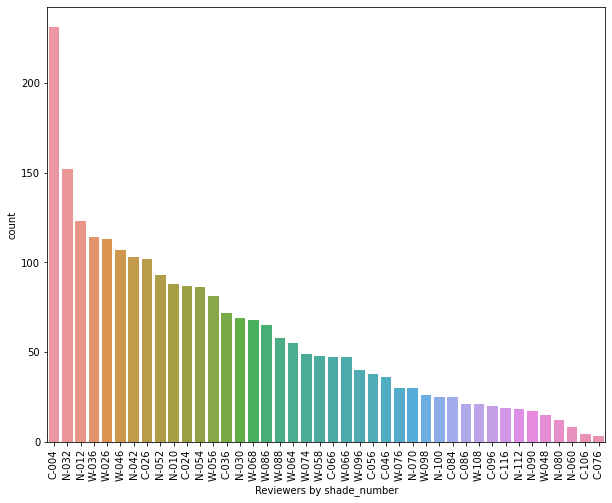

In [21]:
plot_countbar(data=dat, product = product, col1 = 'shade_number')

#### Or can we learn more about the reviews based on reviewer features, such as skin tones, skin types, hair colors, or eye colors?

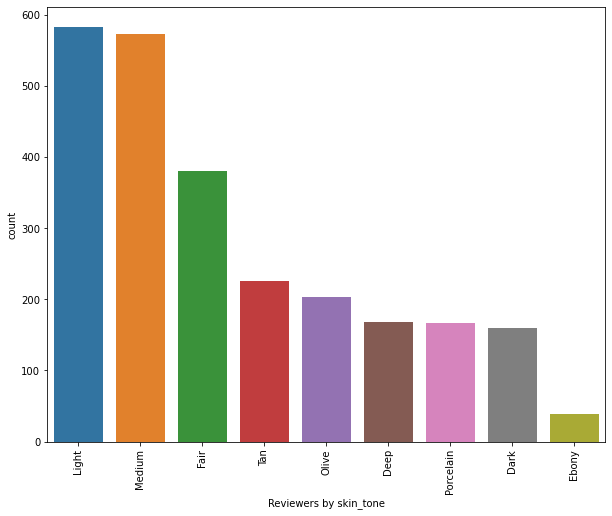

In [22]:
plot_countbar(data = dat, col1 = 'skin_tone', product = product)

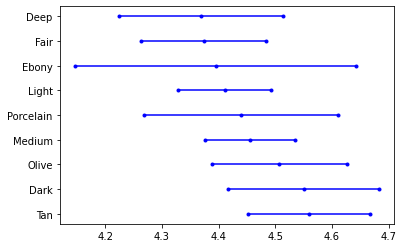

In [23]:
plot_diff_in_means(dat, col1 = 'skin_tone', col2 = 'rating', product = product)

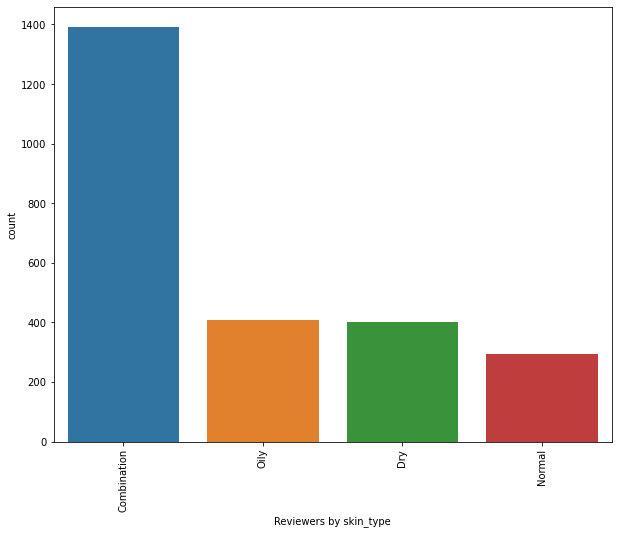

In [24]:
plot_countbar(data = dat, product = product, col1 = 'skin_type')

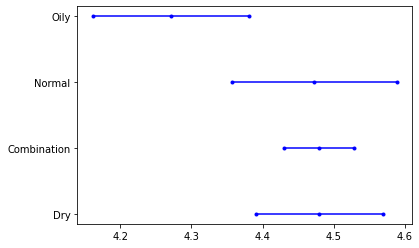

In [25]:
plot_diff_in_means(dat, col1 = 'skin_type', col2 = 'rating', product = product)

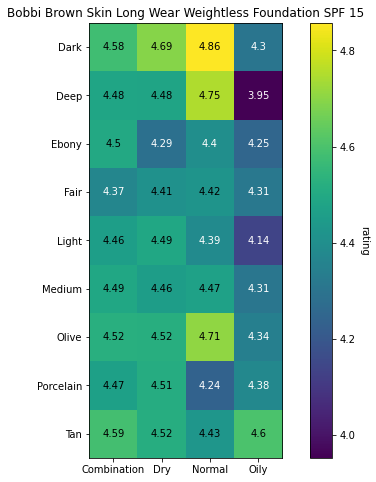

In [26]:
plot_cross_tab_heatmap(data = dat, col1='skin_tone', col2='skin_type', col3 = 'rating', func='mean', product = product)

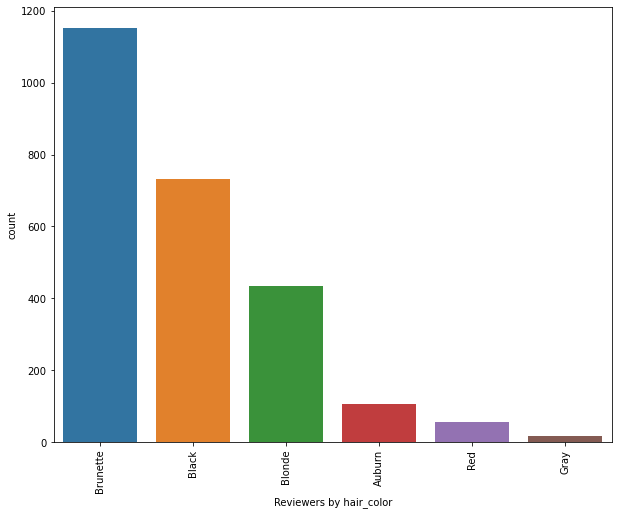

In [27]:
plot_countbar(data = dat, product = product, col1 = 'hair_color')

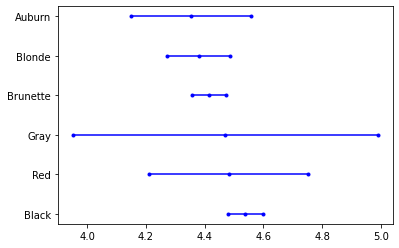

In [28]:
plot_diff_in_means(dat, col1 = 'hair_color', col2 = 'rating', product = product)

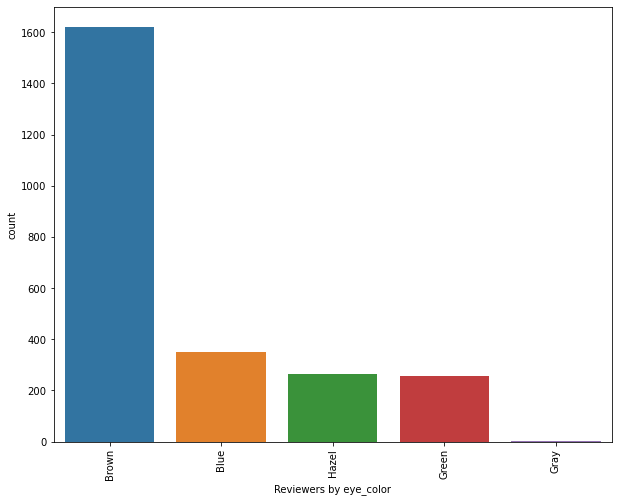

In [29]:
plot_countbar(data = dat, product= product, col1 = 'eye_color')

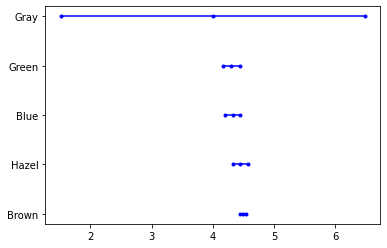

In [30]:
plot_diff_in_means(dat, col1 = 'eye_color', col2 = 'rating', product = product)

In [31]:
dat = dat.sample(frac=1, random_state = 0)

#### What were people talking about when they gave different ratings to this foundation?

In [32]:
# dat_5star = dat[dat['rating']==5]
# dat_4star = dat[dat['rating']==4]
# dat_3star = dat[dat['rating']==3]
# dat_2star = dat[dat['rating']==2]
# dat_1star = dat[dat['rating']==1]

In [33]:
# def nmf_topics_from_review_subject(data, n_features: int, n_components: int, n_top_words: int):
#     # tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english', ngram_range=(1, 2))
#     topic_dat = data[data['review_subject'].notna()]

#     pattern = '|'.join(['foundation','ve', 'really', 'lo', 'ry', 'amorepacific'])
#     topic_dat.loc[:, 'review_subject'] = topic_dat.loc[:, 'review_subject'].str.replace(pattern, '', regex = True)
    
#     # tf = tf_vectorizer.fit_transform(topic_dat['review_subject'])
    
#     tfidf_vectorizer = TfidfVectorizer(max_df=0.99, min_df=1,
#         max_features=n_features, stop_words='english', ngram_range=(1, 2))
#     tfidf = tfidf_vectorizer.fit_transform(topic_dat['review_subject'])

#     nmf = NMF(n_components = n_components, random_state=3,
#           init='nndsvd')# .fit(upc_tf) # nndsvd for sparse data
# #          alpha=.1, l1_ratio=.5)
#     nmf_fit = nmf.fit(tfidf)

#     print("\nTopics in NMF model (Frobenius norm):")
#     tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

#     def print_top_words(model, feature_names, n_top_words = n_top_words):
#         for topic_idx, topic in enumerate(model.components_):
#             message = "Topic #%d: " % topic_idx
#             message += " ".join([feature_names[i]
#                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
#             print(message)
#         print()

#     return print_top_words(nmf_fit, tfidf_feature_names, n_top_words) 

In [34]:
def nmf_topics_from_review_content(data, n_features: int, n_components: int, n_top_words: int):
    # tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english', ngram_range=(1, 2))
    topic_dat = data[data['review_content'].notna()]

    pattern = '|'.join(['foundation','ve', 'really', 'lo', 'ry'])
    topic_dat.loc[:, 'review_content'] = topic_dat.loc[:, 'review_content'].str.replace(pattern, '', regex = True)
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99, min_df=1,
        max_features=n_features, stop_words='english', ngram_range=(1, 2))
    tfidf = tfidf_vectorizer.fit_transform(topic_dat['review_content'])

    nmf = NMF(n_components = n_components, random_state=3,
          init='nndsvd')# .fit(upc_tf) # nndsvd for sparse data
#          alpha=.1, l1_ratio=.5)
    nmf_fit = nmf.fit(tfidf)

    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    def print_top_words(model, feature_names, n_top_words = n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            message = "Topic #%d: " % topic_idx
            message += " ".join([feature_names[i]
                                for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
        print()

    return print_top_words(nmf_fit, tfidf_feature_names, n_top_words) 

In [35]:
# nmf_topics_from_review_content(data = dat_1star, n_features = 1000, n_components = 10, n_top_words = 10)


In [36]:
nmf_topics_from_review_content(data = dat[dat['rating']==5], n_features = 1000, n_components = 7, n_top_words = 10)



Topics in NMF model (Frobenius norm):
Topic #0: ha oily skin day face oily skin didn just don did
Topic #1: weightless wear wear weightless foundation long long wear skin long weightless foundation skin brown skin
Topic #2: gifted gifted bobbi bobbi bobbi brown brown product recommend amazing ng definitely
Topic #3: complimenta receid complimenta bobbi product receid product product complimenta receid complimenta bobbi brown bobbi brown
Topic #4: tone skin tone skin perfectly matches matches skin tone perfectly cor match skin shade
Topic #5: finish skin matte natural like medium oks medium corage ok corage
Topic #6: light weight light weight feels corage super light feels light great medium great corage



/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [37]:
# nmf_topics_from_review_content(data = dat_4star, n_features = 1000, n_components = 25, n_top_words = 10)

In [38]:
# nmf_topics_from_review_subject(data = dat_3star, n_features = 1000, n_components = 15, n_top_words = 10)


In [39]:
# def LDA_topics_from_review_content(data, n_features: int, n_top_words: int):
    
#     topic_dat = data[data['review_content'].notna()]
#     pattern = '|'.join(['foundation','ve', 'really', 'lo', 'ry', 'bobbi brown'])
#     topic_dat.loc[:, 'review_content'] = topic_dat.loc[:, 'review_content'].replace(pattern, '', regex = True)
    
#     tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=1, 
#     max_features=n_features, stop_words='english', ngram_range=(1, 2))
#     tfidf = tfidf_vectorizer.fit_transform(topic_dat['review_content'])

#     lda = LatentDirichletAllocation(learning_method='online')
#     search_params = {
#     'n_components': [5, 10, 15, 20, 25, 30],
#     'learning_decay': [.3, .5, .7]
#     }
#     gridsearch = GridSearchCV(lda, param_grid=search_params, n_jobs=-1, verbose=1).fit(tfidf)
#     print(gridsearch.best_params_)
#     LDA_optimized = LatentDirichletAllocation(
#         n_components=gridsearch.best_params_.get('n_components'), 
#         learning_decay=gridsearch.best_params_.get('learning_decay'),
#         random_state=0)
#     LDA_optimized_fit = LDA_optimized.fit(tfidf)

#     print("\nTopics in LDA model:")
#     tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

#     def print_top_words(model, feature_names, n_top_words = n_top_words):
#         for topic_idx, topic in enumerate(model.components_):
#             message = "Topic #%d: " % topic_idx
#             message += " ".join([feature_names[i]
#                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
#             print(message)
#         print()

#     return print_top_words(LDA_optimized_fit, tfidf_feature_names, n_top_words) 

In [40]:
# LDA_topics_from_review_content(data = dat_5star, n_features=1000, n_top_words=15)

In [41]:
# LDA_topics_from_review_content(data = dat_1star, n_features=1000, n_top_words=15)

In [42]:
# LDA_topics_from_review_content(data = dat_4star, n_features=1000, n_top_words=15)

##### Decided to remove the reviews that had something to do with packaging or bottle design

In [43]:
len(dat[dat['review_content'].isna()]) 

195

In [44]:
list_of_example_reviews_about_bottles = []
dat = dat[dat['review_subject'].notna()]
indices = dat.index
for i in indices:
    if re.match(r'.*packag|design|size|smell*.', dat.loc[i, 'review_subject']):
        list_of_example_reviews_about_bottles.append(i)


In [45]:
len(list_of_example_reviews_about_bottles)

0

In [46]:
# dat.loc[list_of_example_reviews_about_bottles[0], 'review_subject']

In [47]:
dat = dat.drop(dat.index[list_of_example_reviews_about_bottles])

In [48]:
len(dat)

1853

##### And create a feature if revieweres liked matte finishes

In [142]:
dat['finish'] = 0
dat['coverage'] = 0

In [143]:
list_of_positive_reviews_about_matte_finishes = []
dat = dat[dat['review_content'].notna()]
indices = dat.index
for i in indices:
    if re.match(r'.*finish|matte|natural*.', dat.loc[i, 'review_content']):
        if dat.loc[i, 'rating'] >= 4:
            dat.loc[i, 'finish'] = 1
            list_of_positive_reviews_about_matte_finishes.append(i)

In [144]:
len(list_of_positive_reviews_about_matte_finishes)

372

In [141]:
list_of_positive_reviews_about_natural_finishes = []
for i in indices:
    if re.match(r'.*finish|natural*.', dat.loc[i, 'review_content']):
        if dat.loc[i, 'rating'] >= 4:
            list_of_positive_reviews_about_natural_finishes.append(i)
len(list_of_positive_reviews_about_natural_finishes)

372

In [52]:
list_of_positive_reviews_about_coverage = []
# dat_5star = dat_5star[dat_5star['review_content'].notna()]
# indices = dat_5star.index
for i in indices:
    if re.match(r'.*coverage|cover*.', dat.loc[i, 'review_content']):
        if dat.loc[i, 'rating'] >= 4:
            dat.loc[i, 'coverage'] = 1
            list_of_positive_reviews_about_coverage.append(i)

In [53]:
len(list_of_positive_reviews_about_coverage)

821

In [54]:
sum(dat['coverage']) / len(dat)

0.44330453563714906

In [55]:
dat['shade_match'] = 0
list_of_positive_reviews_about_shade = []
for i in indices:
    if re.match(r'.*shade|match*.', dat.loc[i, 'review_content']):
        if dat.loc[i, 'rating'] >= 4:
            dat.loc[i, 'shade_match'] = 1
            list_of_positive_reviews_about_shade.append(i)

In [56]:
len(list_of_positive_reviews_about_shade)

435

In [57]:
dat['gifted'] = 0
list_of_positive_reviews_but_gifted = []
for i in indices:
    if re.match(r'.*gifted|receive|incentivize|receid|compliment*.', dat.loc[i, 'review_content']):
        if dat.loc[i, 'rating'] >= 4:
            dat.loc[i, 'gifted'] = 1
            list_of_positive_reviews_but_gifted.append(i)

In [58]:
len(list_of_positive_reviews_but_gifted)

454

### Preparing the training and validation sets

In [59]:
dat['skin_tone_cat'] = 0

for i in dat.index:
    if dat.loc[i, 'skin_tone'] == 'Dark' or dat.loc[i, 'skin_tone'] == 'Ebony' or dat.loc[i, 'skin_tone'] == 'Deep':
        dat.loc[i, 'skin_tone_cat'] = 0 # darker skin tone = 0
    else:
        dat.loc[i, 'skin_tone_cat'] = 1 # ligher skin tone = 1

In [60]:
reviewer_features = ['hair_color', 'eye_color', 'skin_tone', 'skin_type', 'skin_tone_cat', 'matte_finish', 'coverage', 'shade_match', 'gifted', 'days_since_launch_scaled']

X = dat[reviewer_features]
# y = dat['rating']
dat.loc[:, '5-stars'] = np.where(dat.loc[:, 'rating']==5,1,0)
# y = dat['5-stars']
y = dat['recommended']


train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=0)

In [61]:
sum(y)/len(dat)

0.9017278617710583

In [62]:
len(train_X)

1296

In [63]:
sum(train_X['coverage'])/len(train_X)

0.45524691358024694

In [64]:
sum(train_X['shade_match'])/len(train_X)

0.22993827160493827

In [65]:
sum(train_X['gifted'])/len(train_X)

0.24614197530864199

In [66]:
np.mean(train_X['days_since_launch_scaled'])

0.6147623085429458

#### One-hot Encoding Reviewer Features

##### Hair colors and eye colors

In [67]:
enc_rest = OneHotEncoder(sparse=False)
train_X_transform = enc_rest.fit_transform(train_X[['hair_color', 'eye_color']])
val_X_transform = enc_rest.transform(val_X[['hair_color', 'eye_color']])

train_X_transform = pd.DataFrame(train_X_transform)
val_X_transform = pd.DataFrame(val_X_transform)

In [68]:
train_X_transform.shape

(1296, 11)

In [69]:
train_X.groupby(['hair_color'],as_index=False).count()

,hair_color,eye_color,skin_tone,skin_type,skin_tone_cat,matte_finish,coverage,shade_match,gifted,days_since_launch_scaled
0,Auburn,51,51,51,51,51,51,51,51,51
1,Black,371,371,371,371,371,371,371,371,371
2,Blonde,215,215,215,215,215,215,215,215,215
3,Brunette,620,620,620,620,620,620,620,620,620
4,Gray,7,7,7,7,7,7,7,7,7
5,Red,32,32,32,32,32,32,32,32,32


In [70]:
train_X.groupby(['eye_color'],as_index=False).count()

,eye_color,hair_color,skin_tone,skin_type,skin_tone_cat,matte_finish,coverage,shade_match,gifted,days_since_launch_scaled
0,Blue,189,189,189,189,189,189,189,189,189
1,Brown,814,814,814,814,814,814,814,814,814
2,Gray,3,3,3,3,3,3,3,3,3
3,Green,143,143,143,143,143,143,143,143,143
4,Hazel,147,147,147,147,147,147,147,147,147


#### Skin types and skin tones

In [71]:
enc_skin_tone = OneHotEncoder(sparse=False)
train_X_transform_skin_tone = enc_skin_tone.fit_transform(train_X[['skin_tone']])
val_X_transform_skin_tone = enc_skin_tone.transform(val_X[['skin_tone']])

enc_skin_type = OneHotEncoder(sparse=False)
train_X_transform_skin_type = enc_skin_type.fit_transform(train_X[['skin_type']])
val_X_transform_skin_type = enc_skin_type.transform(val_X[['skin_type']])

In [76]:
total_skin_tone = len(train_X.groupby(['skin_tone'],as_index=False).count()) # 10
total_skin_type = len(train_X.groupby(['skin_type'],as_index=False).count()) # 5

train_X_cross = pd.DataFrame()


i = 0 # tone
# j = 0 # type
while i <= total_skin_tone - 1:
    j = 0
    while j <= total_skin_type - 1:
        new_cross = train_X_transform_skin_tone[:,i] * train_X_transform_skin_type[:,j]
        new_cross = pd.Series(new_cross)
        skin_tone_name = train_X.groupby(['skin_tone'],as_index=False).count()['skin_tone'][i]
        skin_type_name = train_X.groupby(['skin_type'],as_index=False).count()['skin_type'][j]
        train_X_cross[f'{skin_tone_name}_{skin_type_name}'] = new_cross
        j += 1
    i += 1
    
train_X_cross.head()

,Dark_Combination,Dark_Dry,Dark_Normal,Dark_Oily,Deep_Combination,Deep_Dry,Deep_Normal,Deep_Oily,Ebony_Combination,Ebony_Dry,...,Olive_Normal,Olive_Oily,Porcelain_Combination,Porcelain_Dry,Porcelain_Normal,Porcelain_Oily,Tan_Combination,Tan_Dry,Tan_Normal,Tan_Oily
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
train_X_transform.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [81]:
train_X_transform_skin_tone = pd.DataFrame(train_X_transform_skin_tone)
train_X_transform_skin_type = pd.DataFrame(train_X_transform_skin_type)
train_frames = [train_X_transform, train_X_transform_skin_tone, train_X_transform_skin_type, train_X_cross]#, train_X[['matte_finish', 'coverage']]]
train_X_transform = pd.concat(train_frames, axis=1)

In [82]:
train_X_transform['matte_finish'] = train_X['matte_finish'].reset_index(drop = True)
train_X_transform['coverage'] = train_X['coverage'].reset_index(drop = True)
train_X_transform['shade_match'] = train_X['shade_match'].reset_index(drop = True)
train_X_transform['gifted'] = train_X['gifted'].reset_index(drop = True)
train_X_transform['days_since_launch_scaled'] = train_X['days_since_launch_scaled'].reset_index(drop = True)

In [83]:
train_X_transform.shape

(1296, 65)

In [84]:
train_X_transform.head()

,0,1,2,3,4,5,6,7,8,9,...,Porcelain_Oily,Tan_Combination,Tan_Dry,Tan_Normal,Tan_Oily,matte_finish,coverage,shade_match,gifted,days_since_launch_scaled
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,0.756684
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0.756016
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0.756684
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.803476
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.320856


##### Same procedure for validation set

In [85]:
val_X.groupby(['skin_type'],as_index=False).count()

,skin_type,hair_color,eye_color,skin_tone,skin_tone_cat,matte_finish,coverage,shade_match,gifted,days_since_launch_scaled
0,Combination,316,316,316,316,316,316,316,316,316
1,Dry,95,95,95,95,95,95,95,95,95
2,Normal,54,54,54,54,54,54,54,54,54
3,Oily,91,91,91,91,91,91,91,91,91


In [86]:
total_skin_tone = len(val_X.groupby(['skin_tone'],as_index=False).count()) # 10
total_skin_type = len(val_X.groupby(['skin_type'],as_index=False).count()) # 5

val_X_cross = pd.DataFrame()

i = 0 # tone
# j = 0 # type
while i <= total_skin_tone - 1:
    j = 0
    while j <= total_skin_type - 1:
        new_cross = val_X_transform_skin_tone[:,i] * val_X_transform_skin_type[:, j]
        new_cross = pd.Series(new_cross)
        val_X_cross[f'{i}_{j}'] = new_cross
        j += 1
    i += 1
    
val_X_cross.head()

,0_0,0_1,0_2,0_3,1_0,1_1,1_2,1_3,2_0,2_1,...,6_2,6_3,7_0,7_1,7_2,7_3,8_0,8_1,8_2,8_3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [87]:
val_X_transform_skin_tone = pd.DataFrame(val_X_transform_skin_tone)
val_X_transform_skin_type = pd.DataFrame(val_X_transform_skin_type)
val_frames = [val_X_transform, val_X_transform_skin_tone, val_X_transform_skin_type, val_X_cross]
val_X_transform = pd.concat(val_frames, axis=1)

In [88]:
val_X_transform['coverage'] = val_X['coverage'].reset_index(drop = True)
val_X_transform['matte_finish'] = val_X['matte_finish'].reset_index(drop = True)
val_X_transform['shade_match'] = val_X['shade_match'].reset_index(drop = True)
val_X_transform['gifted'] = val_X['gifted'].reset_index(drop = True)
val_X_transform['days_since_launch_scaled'] = val_X['days_since_launch_scaled'].reset_index(drop = True)

In [89]:
val_X_transform.head()

,0,1,2,3,4,5,6,7,8,9,...,7_3,8_0,8_1,8_2,8_3,coverage,matte_finish,shade_match,gifted,days_since_launch_scaled
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,0,1,0.755348
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0.803476
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0.761364
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.764037
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1,1,0,1,0.760027


##### About y (rating)

<AxesSubplot:xlabel='recommended', ylabel='count'>

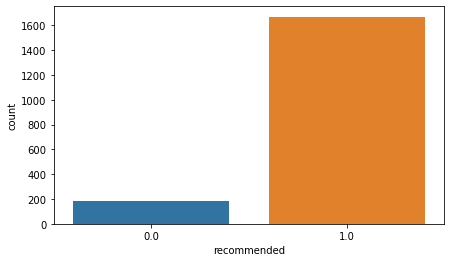

In [90]:
filter_data = dat.dropna(subset=['recommended'])
plt.figure(figsize=(7,4))
sns.countplot(x = filter_data['recommended'])

In [ ]:
# filter_data = dat.dropna(subset=['5-stars'])
# plt.figure(figsize=(7,4))
# sns.countplot(x = filter_data['5-stars'])

In [91]:
sum(y)/len(dat)

0.9017278617710583

In [92]:
len(dat[dat['rating']>=4]) / len(dat)

0.8714902807775378

In [ ]:
## perhaps more labels? 
## why are people taking out stars? due to delivery? shade? 
## keywords? NLP? gauge the "relevance" of the reviews
## shade matching websites? "dupes"
## 

### What are the ratings about?

- Skin tone x rating
- Cross-tabulation of skin tones and skin types vis-a-vis rating

In [ ]:
train_X.groupby(['skin_tone_cat'],as_index=False).count()

In [ ]:
len(train_X_transform_skin_tone.iloc[:, 0])

In [93]:
skin_tone_pearsonr = []
for i in range(9):
    skin_tone_pearsonr.append(st.pearsonr(pd.Series(train_X_transform_skin_tone.iloc[:, i]), train_y))
    # skin_tone_pearsonr.append(skin_tone_labels[i])

In [94]:
skin_tone_pearsonr

[(0.06610104664426997, 0.017315237491340195),
 (-0.0063587356774946115, 0.819105274801697),
 (0.008857565415253512, 0.7500519130760585),
 (-0.0493326517072736, 0.0758413079823579),
 (-0.048044457691382186, 0.08382162907708078),
 (0.041879856378344904, 0.13184112618126023),
 (0.036481617917598914, 0.1893488342654094),
 (-0.020559526393960643, 0.4595992382278096),
 (-4.272249743765208e-05, 0.9987740302441168)]

In [95]:
st.pearsonr(pd.Series(train_X_transform['days_since_launch_scaled']), train_y)

(0.292859292816097, 4.7826886147756614e-27)

In [97]:
st.pearsonr(pd.Series(train_X_transform['shade_match']), train_y)

(0.1785333772137072, 9.603020354943621e-11)

### trying out classification model

#### Logistic Regression

In [ ]:
train_X_transform.columns

In [98]:
logit = LogisticRegression(penalty='none',random_state=0, max_iter=1000, class_weight = 'balanced').fit(train_X_transform, train_y)

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [99]:
predict_y = logit.predict_proba(val_X_transform)[:,1]
# predict_y = logit.predict(val_X_transform)

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

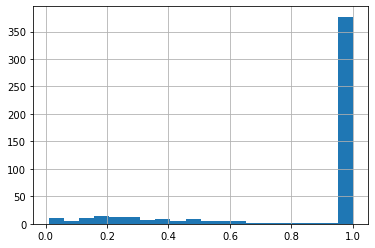

In [100]:
pd.Series(predict_y[val_y == 1.0]).hist(bins=20)

<AxesSubplot:>

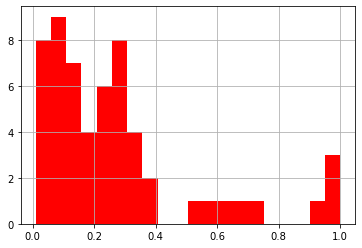

In [101]:
pd.Series(predict_y[val_y == 0.0]).hist(bins=20, color='r')

In [102]:
(predict_y[val_y == 0.0]>0.9).nonzero()

(array([ 1,  4, 15, 36]),)

In [105]:
val_y.index[36]

1820

In [106]:
dat.loc[1820, 'review_content']

'Loved how this felt on my skin! Medium to full coverage with a skin like finish, and with SPF! Dreams do come true!'

In [108]:
dat.loc[1820]

index                                                                    1880
reviewer_id                                                           Marin03
rating                                                                    4.0
recommended                                                               1.0
review_subject                                                        new HG!
review_content              Loved how this felt on my skin! Medium to full...
reviewer_feature                                                  , Oily skin
purchased_shade             Neutral Chestnut (N-100) - rich brown with a b...
date_of_review                                            2019-09-29 00:00:00
eye_color                                                               Brown
hair_color                                                              Black
skin_tone                                                                Dark
skin_type                                                       

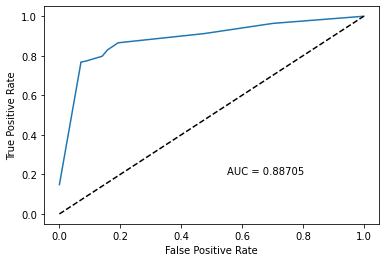

In [109]:
plot_auc_roc(predict_y=predict_y, val_y = val_y, filename = "logit_auc_roc.jpeg")

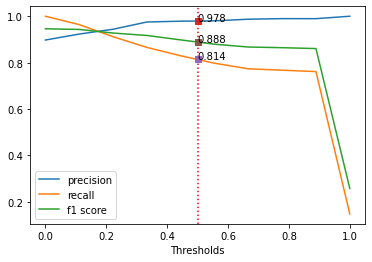

In [110]:
plot_recision_recall_f1(predict_y, val_y, filename="logit_precision_recall_f1.jpeg")

### The logistic regression worked pretty well...

AUC-ROC was about 0.887 with y as 'recommended' (and class_weight = 'balanced')

#### Would another classification model work even better?

In [134]:
svc = SVC(probability=True, class_weight='balanced').fit(train_X_transform,train_y)

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [135]:
predict_y = svc.predict_proba(val_X_transform)[:,1]

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

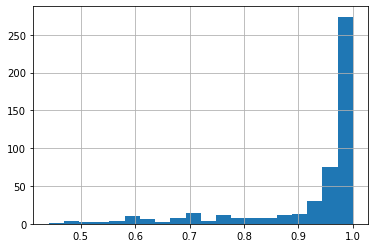

In [136]:
pd.Series(predict_y[val_y == 1.0]).hist(bins=20)

<AxesSubplot:>

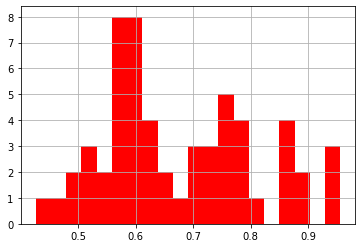

In [137]:
pd.Series(predict_y[val_y == 0.0]).hist(bins=20, color = 'r')

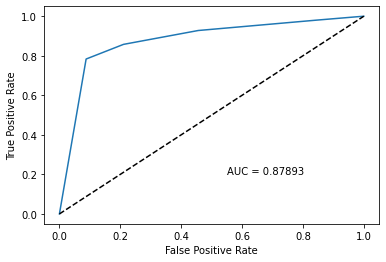

In [138]:
plot_auc_roc(predict_y, val_y, filename = "svc_auc_roc.jpeg")

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


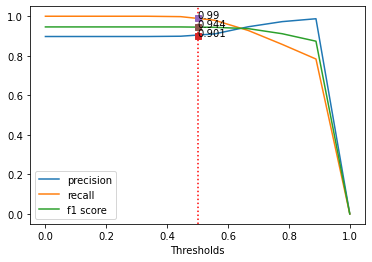

In [139]:
plot_recision_recall_f1(predict_y, val_y, filename = "svc_precision_recall_f1.jpeg")

## trying out random forest models

In [117]:
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier
)


In [118]:
RF = RandomForestClassifier(random_state=0, class_weight='balanced').fit(train_X_transform, train_y)
predict_y = RF.predict_proba(val_X_transform)[:, 1]

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

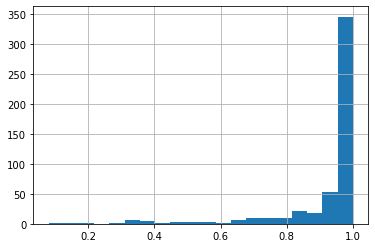

In [120]:
pd.Series(predict_y[val_y == 1.0]).hist(bins=20)

<AxesSubplot:>

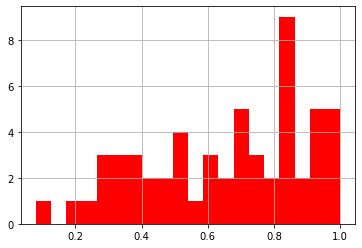

In [121]:
pd.Series(predict_y[val_y == 0.0]).hist(bins=20, color = 'r')

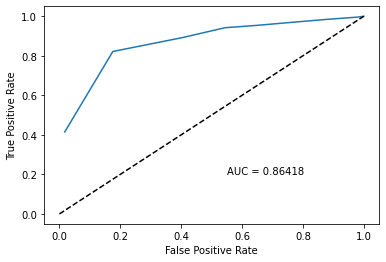

In [119]:
plot_auc_roc(predict_y, val_y, filename = 'RF_auc_roc.jpeg')

In [ ]:
plot_recision_recall_f1(predict_y, val_y, filename = 'RF_precision_recall_f1.jpeg')

In [122]:
Ada = AdaBoostClassifier().fit(train_X_transform, train_y)
predict_y = Ada.predict_proba(val_X_transform)[:, 1]

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

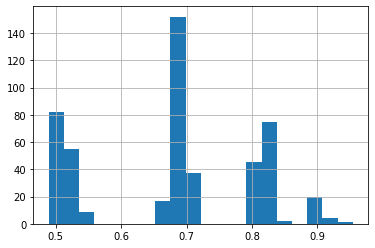

In [123]:
pd.Series(predict_y[val_y == 1.0]).hist(bins=20)

<AxesSubplot:>

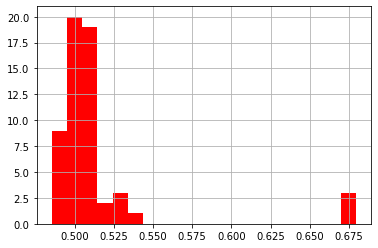

In [124]:
pd.Series(predict_y[val_y == 0.0]).hist(bins=20, color = 'r')

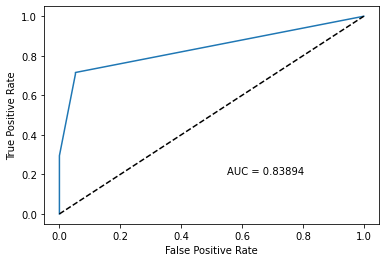

In [125]:
plot_auc_roc(predict_y, val_y, filename= 'adagrad_auc_roc.jpeg')

In [126]:
Bag = BaggingClassifier(n_estimators=1000, random_state=0).fit(train_X_transform, train_y)
predict_y = Bag.predict_proba(val_X_transform)[:, 1]

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

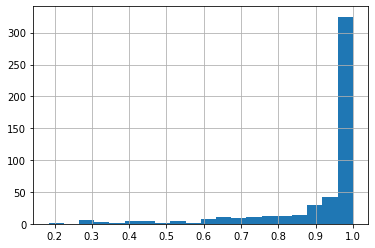

In [127]:
pd.Series(predict_y[val_y == 1.0]).hist(bins=20)

<AxesSubplot:>

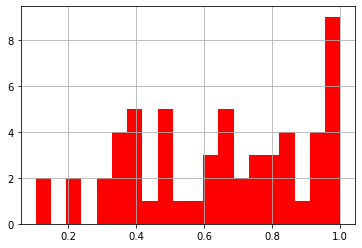

In [128]:
pd.Series(predict_y[val_y == 0.0]).hist(bins=20, color = 'r')

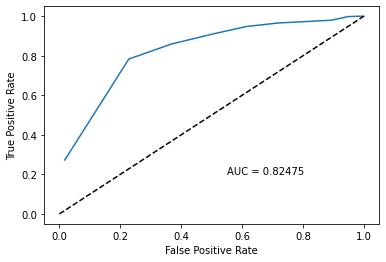

In [129]:
plot_auc_roc(predict_y, val_y, filename = 'bagging_auc_roc.jpeg')

In [130]:
GB = GradientBoostingClassifier(random_state=0).fit(train_X_transform, train_y)
predict_y = GB.predict_proba(val_X_transform)[:, 1]

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

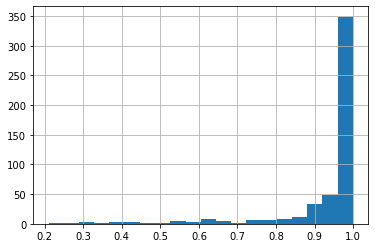

In [131]:
pd.Series(predict_y[val_y == 1.0]).hist(bins=20)

<AxesSubplot:>

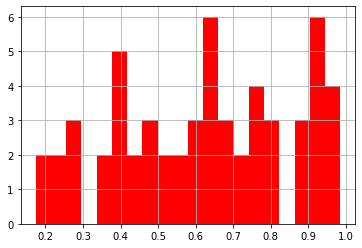

In [132]:
pd.Series(predict_y[val_y == 0.0]).hist(bins=20, color = 'r')

In [ ]:
plot_auc_roc(predict_y, val_y, filename='gdc_auc_roc.jpeg')

In [ ]:
GB_ada = GradientBoostingClassifier(loss='exponential', random_state=0).fit(train_X_transform, train_y)
predict_y = GB_ada.predict_proba(val_X_transform)[:, 1]

In [ ]:
plot_auc_roc(predict_y, val_y, filename = 'GB_ada_auc_roc.jpeg')